In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier

## Exploración de datos

In [2]:
#cargamos el train i el test a un data frame de pandas
jm_train = pd.read_csv("jm_train.csv")
jm_X_test = pd.read_csv("jm_X_test.csv")

In [5]:
#inspeccionamos la información del train 
jm_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 115.0 KB


In [3]:
#inspección de los primeros renglones del train
jm_train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


El train contiene 5 variables numéricas y una categórica, esta última es el variable objetivo. En total tenemos 2100 entradas y ninguna casilla faltante.

Realizemos un gráfico de pastel con los porcentajes de distribución de la variable categórica:

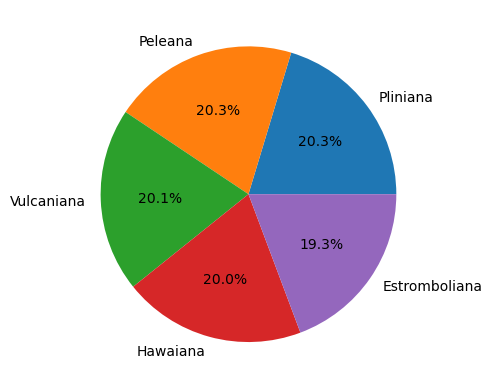

In [6]:
pie_chart = jm_train["target"].value_counts(normalize=True) * 100

plt.pie(pie_chart,autopct="%1.1f%%", labels = ["Pliniana","Peleana","Vulcaniana","Hawaiana","Estromboliana"])
plt.show()

La distribución de porcentajes de cada tipo de erupción es bastante equilibrada, categoría contiene aproximadamente un 20% de las entradas, no será necesario utilizar ninguna técnica de remuestreo.

Procedamos a analizar las variables numéricas:

In [18]:
jm_train.drop(labels=["target"], axis=1).describe()

,feature1,feature2,feature3,feature4,feature5,feature6
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324


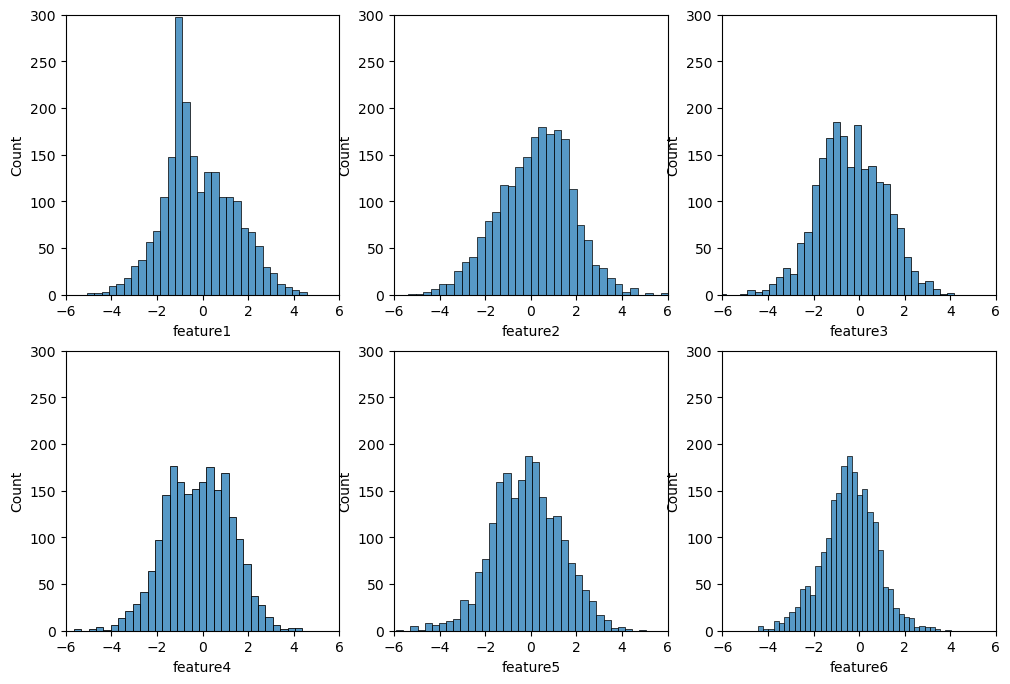

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(12,8))

sns.histplot(jm_train, x="feature1",  palette="deep",ax=axs[0, 0])
sns.histplot(jm_train, x="feature2",  ax=axs[0, 1])
sns.histplot(jm_train, x="feature3",  ax=axs[0, 2])

sns.histplot(jm_train, x="feature4",  ax=axs[1, 0])
sns.histplot(jm_train, x="feature5",  ax=axs[1, 1])
sns.histplot(jm_train, x="feature6", ax=axs[1, 2])

axs[0,0].set_xlim(-6,6)
axs[0,1].set_xlim(-6,6)
axs[0,2].set_xlim(-6,6)
axs[1,0].set_xlim(-6,6)
axs[1,1].set_xlim(-6,6)
axs[1,2].set_xlim(-6,6)

axs[0,0].set_ylim(0,300)
axs[0,1].set_ylim(0,300)
axs[0,2].set_ylim(0,300)
axs[1,0].set_ylim(0,300)
axs[1,1].set_ylim(0,300)
axs[1,2].set_ylim(0,300)


plt.show()

De los valores contenidos en la tabla describe y los gráficos de los histogramas se concluye que todas las variables numéricas tienen una distribución bastante simétrica, en forma de campana y centrada.

Finalmente realizamos un pairplot de las variables numéricas y coloreamos cada punto con los valores de la variable objetivo:

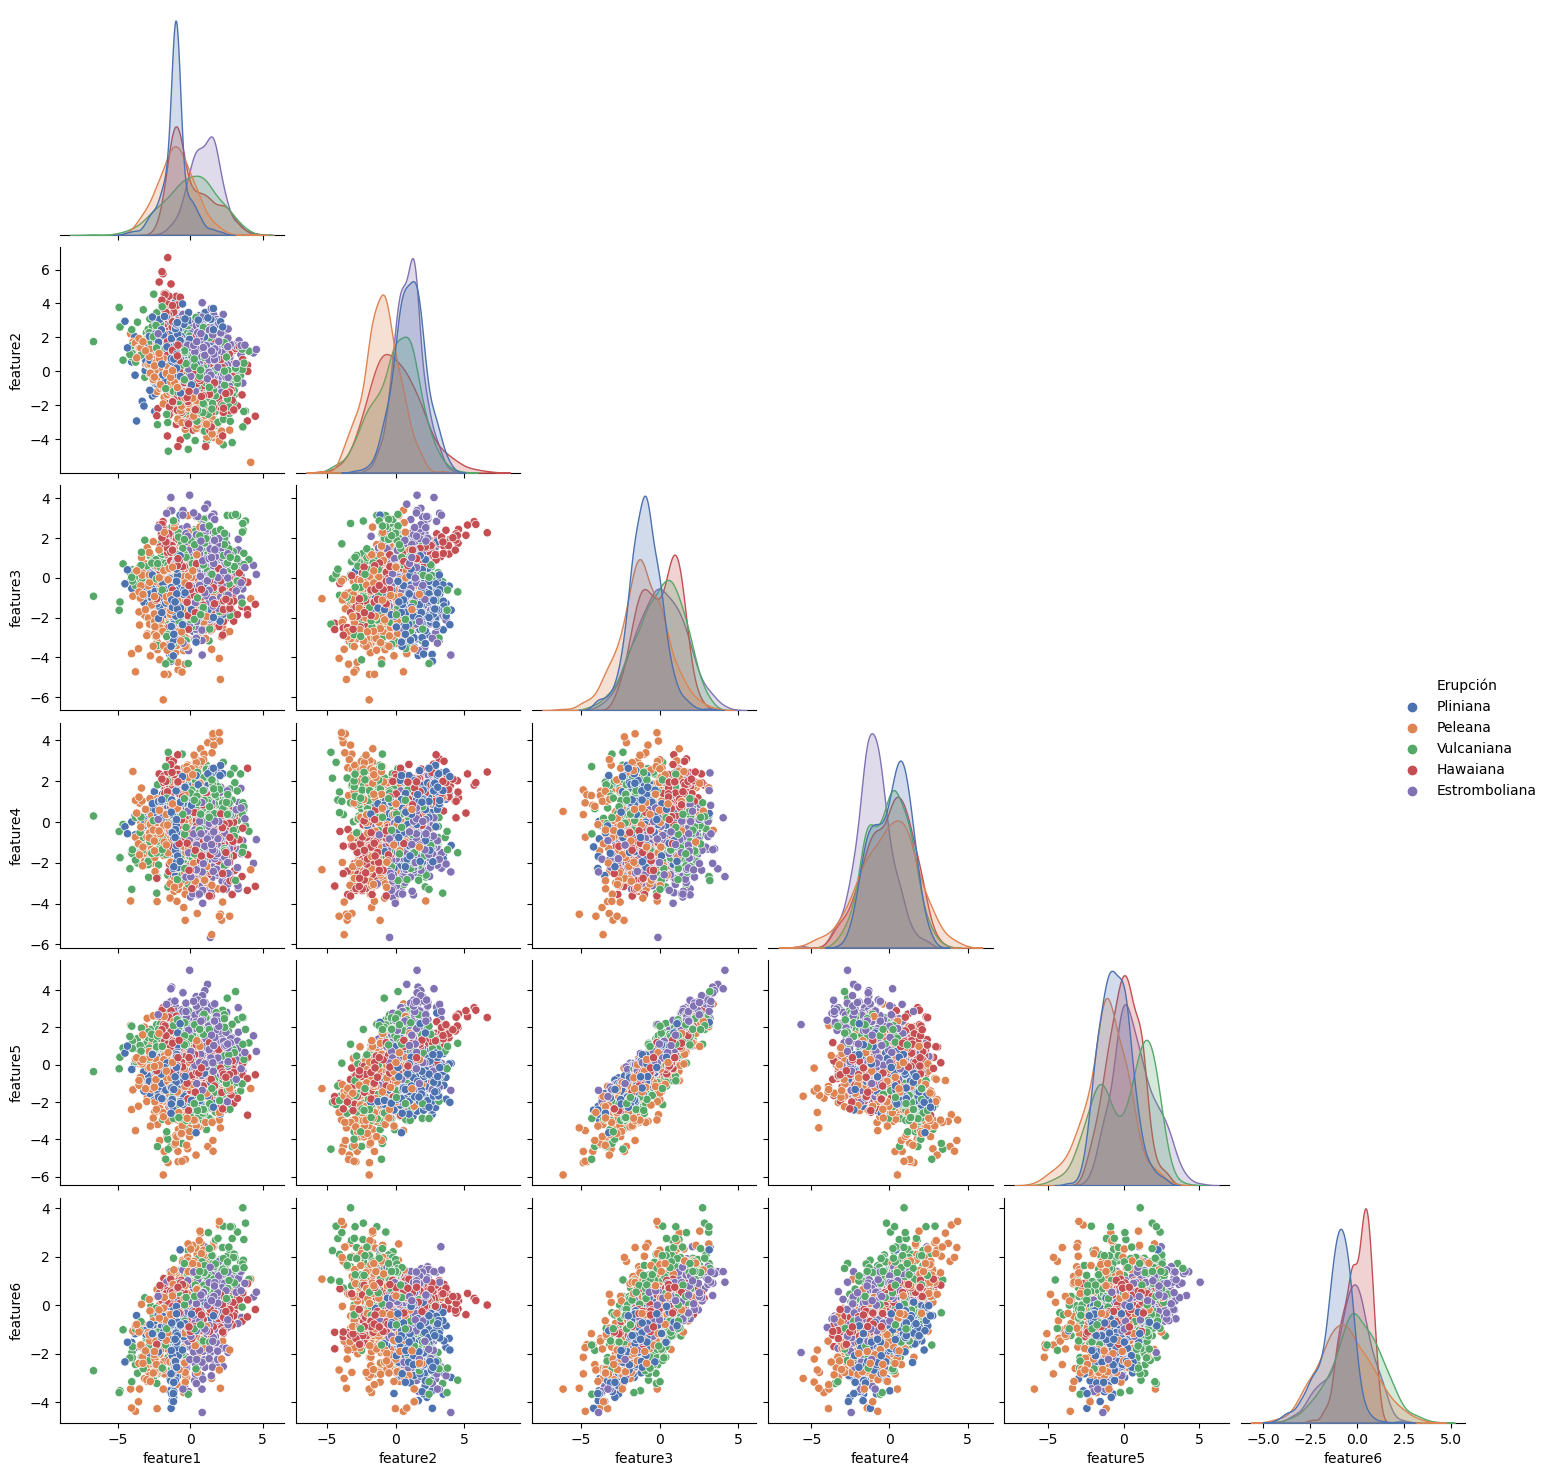

In [26]:
g=sns.pairplot(jm_train, hue="target",corner= True,palette = "deep" )

new_title = 'Erupción'
g._legend.set_title(new_title)

new_labels = ["Pliniana","Peleana","Vulcaniana","Hawaiana","Estromboliana"]
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

#sns.move_legend(g, loc="upper right")


plt.show()

Todos los gráficos de la cuadrícula presentan un buen grado de dispersión respecto a cada tipo de erupción. En los histogramas  las categorías presentan una forma de campana o doble campana.

## Modelo predictivo

Realizemos el modelo predictivo de __Random Forest Classifier (RFC)__. Primero asignemos las variables independientes y la objetivo:

In [9]:
x_train = jm_train[["feature1","feature2","feature3","feature4","feature5","feature6"]]
y_train = jm_train[["target"]].values.ravel()

Hacemos un primer modelo, escalando las variables con __Robust Scaler__ y posterioremente utilizando los parámetros estandar del __RFC__. Evaluamos su precisión a través de una validación cruzada:

In [10]:
pipe = Pipeline([('scaler', RobustScaler()), ('RFC', RandomForestClassifier(random_state=7))])

score = cross_val_score( pipe, x_train, y_train, cv = 5,scoring = "f1_macro")
score_mean = score.mean()
score_var = np.var(score)

print("Media f1_macro: "+str(score_mean))
print("Varianza f1_macro: " + str(score_var))

Media f1_macro: 0.7682874945132088
Varianza f1_macro: 0.00010922253511090809


Procedemos al ajuste de parámetros. Primero utilizamos el método __Randomized Search__:

In [11]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['sqrt',"log2",None]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'RFC__n_estimators': n_estimators,
               'RFC__max_features': max_features,
               'RFC__max_depth': max_depth,
               'RFC__min_samples_split': min_samples_split,
               'RFC__min_samples_leaf': min_samples_leaf,
               'RFC__bootstrap': bootstrap}


search = RandomizedSearchCV(pipe, param_distributions=random_grid,scoring = "f1_macro",n_jobs=-1)

search.fit(x_train, y_train)
search.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('RFC',
                 RandomForestClassifier(max_depth=80, max_features='log2',
                                        n_estimators=400, random_state=7))])

Evaluemos el rendimiento del modelo obtenido a través de validación cruzada:

In [12]:
pipe = Pipeline([('scaler', RobustScaler()), ('RFC', RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       n_estimators=400, random_state=7))])

score = cross_val_score( pipe, x_train, y_train, cv = 5,scoring = "f1_macro")
score_mean = score.mean()
score_var = np.var(score)

print("Media f1_macro: "+str(score_mean))
print("Varianza f1_macro: " + str(score_var))

Media f1_macro: 0.7751448946002396
Varianza f1_macro: 0.00019936817032036375


Se detecta una mejora respecto al modelo anterior. Terminamos de ajustar el modelo utilizando un método de busqueda de ajuste estandar, utilizando pequeños intervalos alrededor de los últimos parámetros encontrados:

In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 600, num = 9)]
# Maximum number of levels in tree
max_depth = [30,40,50,60,70]
# Minimum number of samples required to split a node
min_samples_split = [ 2, 4, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3, 5]
# Create the random grid
bootstrap = [False]
max_features=['log2']

param_grid = {'RFC__n_estimators': n_estimators, 
              'RFC__max_depth': max_depth,
              'RFC__min_samples_split': min_samples_split,
              'RFC__min_samples_leaf': min_samples_leaf, 
              'RFC__bootstrap':bootstrap, 
              'RFC__max_features':max_features
             }


search = GridSearchCV(pipe, param_grid=param_grid,scoring = "f1_macro",n_jobs=-1)

search.fit(x_train, y_train)
search.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('RFC',
                 RandomForestClassifier(bootstrap=False, max_depth=30,
                                        max_features='log2',
                                        min_samples_split=4, n_estimators=200,
                                        random_state=7))])

Evaluamos su rendimiento:

In [14]:
pipe = Pipeline([('scaler', RobustScaler()), ('RFC', RandomForestClassifier(bootstrap=False, max_depth=30, max_features='log2',
                       min_samples_split=4, n_estimators=200, random_state=7))])

score = cross_val_score( pipe, x_train, y_train, cv = 5,scoring = "f1_macro")
score_mean = score.mean()
score_var = np.var(score)

print("Media f1_macro: "+str(score_mean))
print("Varianza f1_macro: " + str(score_var))

Media f1_macro: 0.7774362212306769
Varianza f1_macro: 0.00025140411883584014


Se observa una pequeña mejora, escogeremos el modelo con estos parámetros. Procedmos a ajustar el modelo utilizando todo el conjunto de entrenamiento:

In [15]:
pipe.fit(x_train,y_train)

Realizamos la predicción sobre el cojunto de prueba y cargamos los resultados a un dataframe:

In [16]:
jm_X_predict = pipe.predict(jm_X_test)
jm_X_predict = pd.DataFrame(jm_X_predict)
jm_X_predict.columns = ["final_status"]
jm_X_predict

,final_status
0,1
1,3
2,2
3,0
4,3
...,...
895,3
896,4
897,0
898,3


Finalmente cargamos las predicciones a un csv con las características solicitadas:

In [17]:
jm_X_predict.to_csv("jm_X_pred.csv", sep='\n', index= False )